# <b>Avalia o comportamento das Requests</b>

Como e quando as requests são atendidas.

In [1]:
# Importando as dependências
from quantumnet.components import Controller, Network
from quantumnet.objects import time
from simulations.simulation import Sim 

In [2]:
received_requests = {}
successful_requests = {}
fulfilled_requests = {}

<b>Proativo</b>

In [3]:
# Parâmetros da simulação
network_info = {
    'n_initial_qubits': 10,
    'n_initial_eprs': 10,
    'topology_name': 'Grade',
    'topology_params': (3, 4),
    'time_to_refill': 10,
}
controller_info = {
    'default_ttl': 500,
}
request_info = {
    'num_hosts': 12,
    'n_requests': 100,
    'traffic_type': 'random',
    'burst_probability': 0.3,
    'burst_size': 2,
    'fmin_range': (0.5, 1.0),
    'eprs_range': (1, 10),
}

# Inicializando a simulação
sim = Sim(network_info, controller_info, request_info)

# Parâmetros para preencher as tabelas de forma proativa
proactive_params = {
    1 : { 'frange': (0.5, 0.6), 'neprs': 10 },
    2 : { 'frange': (0.6, 0.7), 'neprs': 10 },
    3 : { 'frange': (0.7, 0.8), 'neprs': 10 },
    4 : { 'frange': (0.8, 0.9), 'neprs': 10 },
    5: { 'frange': (0.9, 1.0), 'neprs': 10 },
}


In [4]:
# Preenche as tabelas de forma proativa
for alice in sim.network.hosts:
    print(f"Adicionando regras para {alice}")
    for bob in sim.network.hosts:
        for key in proactive_params.keys():
            sim.controller.add_match_route_rule_in_host_proactive(alice, bob, proactive_params[key]['frange'], proactive_params[key]['neprs'])
    # Mostra as tabelas
    sim.network.get_host(alice).draw_flow_table()

# Processa as requisições
for request in sim.requests:
    print(f"[Time {time.get_current_time()}]")
    print(f"Request: {request}")
    alice = sim.network.get_host(request.alice)
    rule = alice.find_rule_by_request(request)

    if rule == False:  # Caso não exista um match na tabela
        print(f"Descartando requisição {request} em {alice}")
        request.endtime = time.get_current_time()
        # Registra a requisição descartada
        sim.controller.fulfill_request(request)
        
    else:  # Caso já exista a regra
        request.starttime = time.get_current_time()
        sim.controller.run_rule(rule[1])
        request.endtime = time.get_current_time() + 1        
        # Registra a requisição atendida
        sim.controller.successful_request(request)

    # Atualiza o tempo
    sim.update_time(1)

# Salva as requisições
received_requests['proativo'] = sim.requests
successful_requests['proativo'] = sim.controller.successful_requests
fulfilled_requests['proativo'] = sim.controller.fulfilled_requests

# Fim da simulação
time.reset()


Adicionando regras para 0
+----------------------+----------------------+--------------------+
| Match                | Route                | Rule               |
+======================+======================+====================+
| (0, (0.5, 0.6), 10)  | [0]                  | BasicRuleProactive |
+----------------------+----------------------+--------------------+
| (0, (0.6, 0.7), 10)  | [0]                  | BasicRuleProactive |
+----------------------+----------------------+--------------------+
| (0, (0.7, 0.8), 10)  | [0]                  | BasicRuleProactive |
+----------------------+----------------------+--------------------+
| (0, (0.8, 0.9), 10)  | [0]                  | BasicRuleProactive |
+----------------------+----------------------+--------------------+
| (0, (0.9, 1.0), 10)  | [0]                  | BasicRuleProactive |
+----------------------+----------------------+--------------------+
| (1, (0.5, 0.6), 10)  | [0, 1]               | BasicRuleProactive |
+-------

<b>Reativo</b>

In [5]:
# Parâmetros da simulação
network_info = {
    'n_initial_qubits': 10,
    'n_initial_eprs': 10,
    'topology_name': 'Grade',
    'topology_params': (3, 4),
    'time_to_refill': 10,
}
controller_info = {
    'default_ttl': 50,
}
request_info = {
    'num_hosts': 12,
    'n_requests': 100,
    'traffic_type': 'random',
    'burst_probability': 0.3,
    'burst_size': 2,
    'fmin_range': (0.5, 1.0),
    'eprs_range': (1, 10),
}

# Inicializando a simulação
sim = Sim(network_info, controller_info, request_info)

In [6]:
for request in sim.requests:
        print(f"[Time {time.get_current_time()}] Processando requisição {request}...")
        alice = sim.network.get_host(request.alice)
        rule = alice.find_rule_by_request(request)

        if rule == False:  # Caso não exista um match na tabela
            request.starttime = time.get_current_time()
            sim.update_time(3)
            sim.controller.add_match_route_rule_in_host_reactive(request)
            rule = alice.find_rule_by_request(request)
            
        else:  # Caso já exista a regra
            request.starttime = time.get_current_time()
            sim.update_time(1)
                
        # Executa a regra
        sim.controller.run_rule(rule[1])
        request.endtime = time.get_current_time()
        # Registra a requisição atendida
        sim.controller.successful_request(request)
        
        # Exibir informações da requisição
        print(f"Request {request}: Start Time = {request.starttime}, End Time = {request.endtime}")

# Salva as requisições
received_requests['reativo'] = sim.requests
successful_requests['reativo'] = sim.controller.successful_requests
fulfilled_requests['reativo'] = sim.controller.fulfilled_requests

# Fim da simulação
time.reset()

[Time 0] Processando requisição RB282C0:1-9:0.91:9...
Decisão aplicada: (High Fidelity,)
Request RB282C0:1-9:0.91:9: Start Time = 0, End Time = 3
[Time 3] Processando requisição RB28500:0-11:0.54:6...
Decisão aplicada: (Normal E2E,)
[BasicRule] Passo: 1
[BasicRule] Passo: 2
[BasicRule] Ação: Swap(0-4-8)
Running Swap(0-4-8)
[BasicRule] Ação: Swap(8-9-10)
Running Swap(8-9-10)
[BasicRule] Passo: 3
[BasicRule] Ação: Swap(0-8-10)
Running Swap(0-8-10)
Request RB28500:0-11:0.54:6: Start Time = 3, End Time = 6
[Time 6] Processando requisição RB28530:1-9:0.67:8...
Decisão aplicada: (Normal E2E,)
[BasicRule] Passo: 1
[BasicRule] Passo: 2
[BasicRule] Ação: Swap(1-5-9)
Running Swap(1-5-9)
Request RB28530:1-9:0.67:8: Start Time = 6, End Time = 9
[Time 9] Processando requisição RB286E0:7-0:0.89:6...
[Time 10] Recursos atualizados
Decisão aplicada: (Normal E2E,)
[BasicRule] Passo: 1
[BasicRule] Passo: 2
[BasicRule] Ação: Swap(7-6-10)
Running Swap(7-6-10)
Request RB286E0:7-0:0.89:6: Start Time = 9, En

<b>Híbrido</b>

In [7]:
# Parâmetros da simulação
network_info = {
    'n_initial_qubits': 10,
    'n_initial_eprs': 10,
    'topology_name': 'Grade',
    'topology_params': (3, 4),
    'time_to_refill': 10,
}
controller_info = {
    'default_ttl': 50,
}
request_info = {
    'num_hosts': 12,
    'n_requests': 100,
    'traffic_type': 'random',
    'burst_probability': 0.3,
    'burst_size': 2,
    'fmin_range': (0.5, 1.0),
    'eprs_range': (1, 10),
}

# Inicializando a simulação
sim = Sim(network_info, controller_info, request_info)

# Parâmetros para preencher as tabelas de forma proativa
proactive_params = {
    1 : { 'frange': (0.5, 0.6), 'neprs': 5 },
    2 : { 'frange': (0.8, 0.9), 'neprs': 5 },
}

In [8]:
# Preenche as tabelas de forma proativa
for alice in sim.network.hosts:
    print(f"Adicionando regras para {alice}")
    for bob in sim.network.hosts:
        for key in proactive_params.keys():
            sim.controller.add_match_route_rule_in_host_proactive(alice, bob, proactive_params[key]['frange'], proactive_params[key]['neprs'])
    # Mostra as tabelas
    sim.network.get_host(alice).draw_flow_table()

# Processa as requisições e preenche as tabelas de forma reativa
for request in sim.requests:
        print(f"[Time {time.get_current_time()}] Processando requisição {request}...")
        alice = sim.network.get_host(request.alice)
        rule = alice.find_rule_by_request(request)

        if rule == False:  # Caso não exista um match na tabela
            request.starttime = time.get_current_time()
            sim.update_time(3)
            sim.controller.add_match_route_rule_in_host_reactive(request)
            rule = alice.find_rule_by_request(request)
            
        else:  # Caso já exista a regra
            request.starttime = time.get_current_time()
            sim.update_time(1)
                
        # Executa a regra
        sim.controller.run_rule(rule[1])
        request.endtime = time.get_current_time()
        # Registra a requisição atendida
        sim.controller.successful_request(request)
        
        # Exibir informações da requisição
        print(f"Request {request}: Start Time = {request.starttime}, End Time = {request.endtime}")

# Salva as requisições
received_requests['hibrido'] = sim.requests
successful_requests['hibrido'] = sim.controller.successful_requests
fulfilled_requests['hibrido'] = sim.controller.fulfilled_requests

# Fim da simulação
time.reset()

Adicionando regras para 0
+---------------------+----------------------+--------------------+
| Match               | Route                | Rule               |
+=====================+======================+====================+
| (0, (0.5, 0.6), 5)  | [0]                  | BasicRuleProactive |
+---------------------+----------------------+--------------------+
| (0, (0.8, 0.9), 5)  | [0]                  | BasicRuleProactive |
+---------------------+----------------------+--------------------+
| (1, (0.5, 0.6), 5)  | [0, 1]               | BasicRuleProactive |
+---------------------+----------------------+--------------------+
| (1, (0.8, 0.9), 5)  | [0, 1]               | BasicRuleProactive |
+---------------------+----------------------+--------------------+
| (2, (0.5, 0.6), 5)  | [0, 1, 2]            | BasicRuleProactive |
+---------------------+----------------------+--------------------+
| (2, (0.8, 0.9), 5)  | [0, 1, 2]            | BasicRuleProactive |
+---------------------

100
100
100
100
100
100


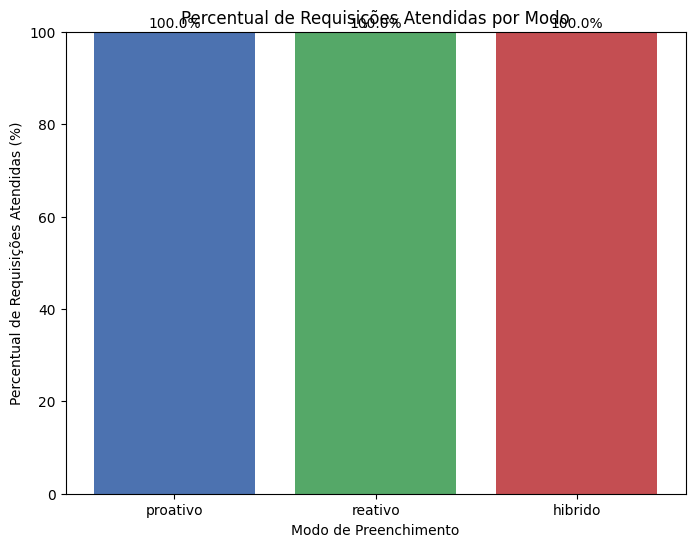

In [9]:
import matplotlib.pyplot as plt

def calcular_percentual_atendimento(requisicoes_recebidas, requisicoes_atendidas):
    # Cálculo do percentual de atendimento por modo
    percentual_atendido = {}
    for modo in requisicoes_recebidas:
        total_recebidas = len(requisicoes_recebidas[modo])
        print(total_recebidas)
        total_atendidas = len(requisicoes_atendidas[modo])
        print(total_atendidas)
        percentual_atendido[modo] = (total_atendidas / total_recebidas) * 100 if total_recebidas > 0 else 0
    return percentual_atendido

percentual = calcular_percentual_atendimento(received_requests, successful_requests)

# Plotagem do gráfico
plt.figure(figsize=(8, 6))
plt.bar(percentual.keys(), percentual.values(), color=['#4c72b0', '#55a868', '#c44e52'])

plt.xlabel('Modo de Preenchimento')
plt.ylabel('Percentual de Requisições Atendidas (%)')
plt.title('Percentual de Requisições Atendidas por Modo')
plt.ylim(0, 100)

# Exibe o valor de cada barra
for i, v in enumerate(percentual.values()):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.show()
